In [ ]:
pip install -r requirements.txt

# 調用package

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import glob

from skimage.feature import graycomatrix, graycoprops
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, classification_report

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

### package版本

In [15]:
import colorama
import sklearn
import skimage
import xgboost
print("pd:", pd.__version__)
print("cv2:", cv2.__version__)
print("np:", np.__version__)
print("colorama:", colorama.__version__)
print("scikit-learn:", sklearn.__version__)
print("skimage:", skimage.__version__)
print("xgboost:", xgboost.__version__)

pd: 1.4.4
cv2: 4.6.0
np: 1.21.5
colorama: 0.4.6
scikit-learn: 1.2.2
skimage: 0.19.3
xgboost: 1.7.1


# 定義前處理function

In [2]:
# 去除外圈
def remove_outerring(image_path):
    # 讀取圖片
    img = cv2.imread(image_path)
    # 設定外圈標的
    outerring_list = [
        [100,101,91],
        [105,106,96],
        [76, 77, 67],
        [115,116,114],
        [136,129,132],
        [128,121,124],
        [166,164,164],
        [151,146,147],
        [90, 87, 79]
    ]
    
    # 對於每種外圈顏色，計算與每個像素的距離
    threshold = 20
    for color in outerring_list:
        distance = np.sqrt(np.sum((img - color) ** 2, axis=-1))
        mask = distance < threshold
        img[mask] = [0, 0, 0]
        
    # 儲存修改後的圖片
    cv2.imwrite(image_path, img)
    return img

In [2]:
# 二值化
def process_image(image_path):
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    tile_height, tile_width = height // 6, width // 6
    tiles = [img[i * tile_height:(i + 1) * tile_height, j * tile_width:(j + 1) * tile_width] for i in range(6) for j in range(6)]
    
    white_counts = []
    for tile in tiles:
        gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
        white_count = np.sum(thresh == 255)
        white_counts.append(white_count)
    
    return white_counts

In [3]:
# GLCM features
def GLCM_process(image_path):
    # 讀取資料夾路徑
    image_folder = os.listdir(image_path)
    # 2. 特徵提取
    features = []

    # 計算迴圈次數
    for img in image_folder:
        if img.endswith('.jpg') or img.endswith('.png'):
            # 讀取影像
            image = cv2.imread(os.path.join(image_path, img), cv2.IMREAD_GRAYSCALE)
            
            # 計算GLCM
            glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
            
            # 提取GLCM特徵，使用能量和對比度
            energy = graycoprops(glcm, 'energy')[0, 0]
            dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
            ASM = graycoprops(glcm, 'ASM')[0, 0]
            correlation = graycoprops(glcm, 'correlation')[0, 0]
            
            # 將特徵保存到列表
            feature = [energy, dissimilarity, contrast, homogeneity, ASM, correlation]
            features.append(feature)
            
    GLCM_df = pd.DataFrame(features)
    return GLCM_df

In [3]:
#testtest0704
# GLCM features
def GLCM_process(image_path):
    # 讀取資料夾路徑
    image_folder = os.listdir(image_path)
    # 2. 特徵提取
    features = []
    failed_images = []

    # 計算迴圈次數
    for img in image_folder:
        try:     
            # 讀取影像
            image = cv2.imread(os.path.join(image_path, img), cv2.IMREAD_GRAYSCALE)
            
            # 計算GLCM
            glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
            
            # 提取GLCM特徵，使用能量和對比度
            energy = graycoprops(glcm, 'energy')[0, 0]
            dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
            ASM = graycoprops(glcm, 'ASM')[0, 0]
            correlation = graycoprops(glcm, 'correlation')[0, 0]
            
            # 將特徵保存到列表
            feature = [energy, dissimilarity, contrast, homogeneity, ASM, correlation]
            features.append(feature)
        except:
            failed_images.append(img)
    # 列印出沒有經過GLCM特徵提取的檔案名
    if failed_images:
        print("以下檔案無法成功提取GLCM特徵：")
        for img in failed_images:
            print(img)
            
    GLCM_df = pd.DataFrame(features)
    return GLCM_df


In [41]:
import cv2
import os

def augment_image(image_path, output_dir, rotations):
    # 讀取影像
    image = cv2.imread(image_path)

    # 取得影像檔名和副檔名
    base_name, ext = os.path.splitext(os.path.basename(image_path))

    # 應用旋轉和水平翻轉
    for angle in rotations:
        # 旋轉
        rotated_image = cv2.warpAffine(image, cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1), (image.shape[1], image.shape[0]))
        # 儲存旋轉後的影像
        output_path = os.path.join(output_dir, f"rotated_{angle}_{base_name}{ext}")
        cv2.imwrite(output_path, rotated_image)

    # 水平翻轉
    flipped_image = cv2.flip(image, 1)
    # 儲存水平翻轉後的影像
    output_path = os.path.join(output_dir, f"flipped_{base_name}{ext}")
    cv2.imwrite(output_path, flipped_image)

# 輸入影像的資料夾路徑
input_folder = r"C:\Users\user\Desktop\wafer\231219 MAP\231219 GF1\Dataset2-Augment\not reworkable"

# 輸出影像的資料夾路徑
output_folder = r"C:\Users\user\Desktop\wafer\231219 MAP\231219 GF1\Dataset2-Augment\not reworkable"

# 旋轉的角度
rotation_angles = [15, 30, 45, 60, 75, 90]

# 確保輸出目錄存在
os.makedirs(output_folder, exist_ok=True)

# 迭代資料夾中的所有影像
for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            input_image_path = os.path.join(root, file)
            augment_image(input_image_path, output_folder, rotation_angles)

print("done")


影像資料增強完成。


# 處理Training data

### 外圈

In [6]:
############移除外圈###############
# 循環讀取資料夾中的所有圖像，並處理每個圖像
train_NotReworkable = r"C:\Users\user\Desktop\wafer\third0713\train_demo_1031\not reworkable"
train_Reworkable = r"C:\Users\user\Desktop\wafer\third0713\train_demo_1031\reworkable"
test_NotReworkable = r"C:\Users\user\Desktop\wafer\third0713\test_demo_1031\not reworkable"
test_Reworkable = r"C:\Users\user\Desktop\wafer\third0713\test_demo_1031\reworkable"

image_folder_list = [train_NotReworkable, train_Reworkable, test_NotReworkable, test_Reworkable]
for image_folder in image_folder_list:
    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # 圖像的完整路徑
            image_path = os.path.join(image_folder, filename)
            # 調用process_image函數處理圖像
            img = remove_outerring(image_path)   
    print(f'{image_folder}: done!')

C:\Users\user\Desktop\wafer\third0713\test_demo_1031\not reworkable: done!
C:\Users\user\Desktop\wafer\third0713\test_demo_1031\reworkable: done!


### 二值化

In [4]:
#Label Encoding (train_Reworkable)
tiles_amount = 36
train_Reworkable = r"C:\Users\user\Desktop\wafer\240806 MAP\KID train Model 10\reworkable"
data = []

for image_path in glob.glob(os.path.join(train_Reworkable, "*.jpg")):
    white_counts = process_image(image_path)
    count_list = [count for count in white_counts]
    data.append(count_list)

dfAll = pd.DataFrame(data, columns=[f'Tile_{i}' for i in range(tiles_amount)])
dfAll['label'] = 1

In [5]:
#Label Encoding (train_NotReworkable)
train_NotReworkable = r"C:\Users\user\Desktop\wafer\240806 MAP\KID train Model 10\not reworkable"
data = []

for image_path in glob.glob(os.path.join(train_NotReworkable, "*.jpg")):
    white_counts = process_image(image_path)
    count_list = [count for count in white_counts]
    data.append(count_list)

dfAll2 = pd.DataFrame(data, columns=[f'Tile_{i}' for i in range(tiles_amount)])
dfAll2['label'] = 0

In [6]:
train = pd.concat([dfAll,dfAll2])
train = train.reset_index(drop=True)
train

,Tile_0,Tile_1,Tile_2,Tile_3,Tile_4,Tile_5,Tile_6,Tile_7,Tile_8,Tile_9,...,Tile_27,Tile_28,Tile_29,Tile_30,Tile_31,Tile_32,Tile_33,Tile_34,Tile_35,label
0,26,429,1591,212,210,33,206,0,329,151,...,265,2,206,42,210,184,1579,383,52,1
1,11,307,417,175,187,39,159,82,261,146,...,419,93,198,4,173,146,457,344,30,1
2,56,274,973,274,218,68,159,27,402,722,...,830,32,203,11,169,365,655,226,30,1
3,15,167,156,217,189,34,193,192,56,30,...,23,106,201,0,163,144,141,186,15,1
4,15,154,176,183,161,82,161,88,0,54,...,65,13,215,3,161,151,141,162,64,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,45,215,215,207,219,28,231,125,2598,2824,...,3739,345,229,49,227,177,182,220,131,0
685,45,215,214,207,221,28,230,0,32,39,...,311,0,229,49,226,177,184,223,131,0
686,45,215,214,207,221,28,231,0,1469,1538,...,2060,8,229,49,226,177,184,223,131,0
687,45,215,214,208,221,28,231,36,2070,2241,...,2576,123,224,49,226,177,184,223,131,0


# 二值化+GLCM(Training)

In [7]:
### 加入GLCM特徵
#Label Encoding (train_Reworkable)
train_Reworkable = r"C:\Users\user\Desktop\wafer\240806 MAP\KID train Model 10\reworkable"
glcm_features= GLCM_process(train_Reworkable)
glcm = pd.DataFrame(glcm_features)
#glcm['label'] = 1

#Label Encoding (train_NotReworkable)
train_NotReworkable = r"C:\Users\user\Desktop\wafer\240806 MAP\KID train Model 10\not reworkable"
glcm_features= GLCM_process(train_NotReworkable)
glcm2 = pd.DataFrame(glcm_features)
#glcm2['label'] = 0

train_glcm = pd.concat([glcm,glcm2])
train_glcm = train_glcm.reset_index(drop=True)
train_glcm

,0,1,2,3,4,5
0,0.683688,10.367859,1625.405335,0.747985,0.467430,0.342169
1,0.717708,5.536547,638.201405,0.806586,0.515105,0.649498
2,0.739852,4.329138,415.349732,0.820837,0.547381,0.772301
3,0.691619,7.835184,1228.765545,0.751576,0.478338,0.520665
4,0.725160,5.739458,638.547218,0.807307,0.525858,0.649081
...,...,...,...,...,...,...
672,0.662899,22.794656,5012.227852,0.723289,0.439436,0.521827
673,0.777384,11.705435,2439.206485,0.830583,0.604326,0.723459
674,0.705930,23.537568,5304.180442,0.762139,0.498338,0.507833
675,0.675773,27.431357,6229.239564,0.733234,0.456669,0.444902


In [8]:
train = pd.concat([train,train_glcm], axis=1)
train

,Tile_0,Tile_1,Tile_2,Tile_3,Tile_4,Tile_5,Tile_6,Tile_7,Tile_8,Tile_9,...,Tile_33,Tile_34,Tile_35,label,0,1,2,3,4,5
0,26,429,1591,212,210,33,206,0,329,151,...,1579,383,52,1,0.683688,10.367859,1625.405335,0.747985,0.467430,0.342169
1,11,307,417,175,187,39,159,82,261,146,...,457,344,30,1,0.717708,5.536547,638.201405,0.806586,0.515105,0.649498
2,56,274,973,274,218,68,159,27,402,722,...,655,226,30,1,0.739852,4.329138,415.349732,0.820837,0.547381,0.772301
3,15,167,156,217,189,34,193,192,56,30,...,141,186,15,1,0.691619,7.835184,1228.765545,0.751576,0.478338,0.520665
4,15,154,176,183,161,82,161,88,0,54,...,141,162,64,1,0.725160,5.739458,638.547218,0.807307,0.525858,0.649081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,45,215,215,207,219,28,231,125,2598,2824,...,182,220,131,0,NaN,NaN,NaN,NaN,NaN,NaN
685,45,215,214,207,221,28,230,0,32,39,...,184,223,131,0,NaN,NaN,NaN,NaN,NaN,NaN
686,45,215,214,207,221,28,231,0,1469,1538,...,184,223,131,0,NaN,NaN,NaN,NaN,NaN,NaN
687,45,215,214,208,221,28,231,36,2070,2241,...,184,223,131,0,NaN,NaN,NaN,NaN,NaN,NaN


### 單獨GLCM特徵(Training)

In [15]:
#Label Encoding (train_Reworkable)
train_Reworkable = r"C:\Users\user\Desktop\wafer\third0713\train_mix_new_augment\reworkable"
glcm_features= GLCM_process(train_Reworkable)
dfAll = pd.DataFrame(glcm_features)
dfAll['label'] = 1

#Label Encoding (train_NotReworkable)
train_NotReworkable = r"C:\Users\user\Desktop\wafer\third0713\train_mix_new_augment\not reworkable"
glcm_features= GLCM_process(train_NotReworkable)
dfAll2 = pd.DataFrame(glcm_features)
dfAll2['label'] = 0

train = pd.concat([dfAll,dfAll2])
train = train.reset_index(drop=True)
train

,0,1,2,3,4,5,label
0,0.464360,12.155321,1572.171673,0.562401,0.215631,0.283759,1
1,0.465948,12.597976,1692.507829,0.562169,0.217108,0.187520,1
2,0.464360,12.155321,1572.171673,0.562401,0.215631,0.283759,1
3,0.835412,3.406008,437.643170,0.886721,0.697913,0.697633,1
4,0.846134,3.115845,398.943911,0.895660,0.715943,0.568763,1
...,...,...,...,...,...,...,...
7655,0.183532,34.510075,3738.170294,0.282937,0.033684,0.089689,0
7656,0.183780,37.313227,4388.047373,0.283753,0.033775,0.095731,0
7657,0.498440,26.664204,3819.175936,0.561950,0.248443,0.393873,0
7658,0.197037,14.402785,975.601913,0.337766,0.038823,0.109888,0


# 處理Testing data

In [277]:
#Label Encoding (test_Reworkable)
tiles_amount = 36 #for 6*6 case
test_Reworkable = r"C:\Users\user\Desktop\wafer\231219 MAP\231219 GF1\Dataset2-test\reworkable"
data = []

for image_path in glob.glob(os.path.join(test_Reworkable, "*.jpg")):
    white_counts = process_image(image_path)
    count_list = [count for count in white_counts]
    data.append(count_list)

dfAll = pd.DataFrame(data, columns=[f'Tile_{i}' for i in range(tiles_amount)])
dfAll['label'] = 1

In [278]:
#Label Encoding (test_NotReworkable)
test_NotReworkable = r"C:\Users\user\Desktop\wafer\231219 MAP\231219 GF1\Dataset2-test\not reworkable"
data = []

for image_path in glob.glob(os.path.join(test_NotReworkable, "*.jpg")):
    white_counts = process_image(image_path)
    count_list = [count for count in white_counts]
    data.append(count_list)

dfAll2 = pd.DataFrame(data, columns=[f'Tile_{i}' for i in range(tiles_amount)])
dfAll2['label'] = 0

In [279]:
test = pd.concat([dfAll, dfAll2])
test = test.reset_index(drop=True)
test

,Tile_0,Tile_1,Tile_2,Tile_3,Tile_4,Tile_5,Tile_6,Tile_7,Tile_8,Tile_9,...,Tile_27,Tile_28,Tile_29,Tile_30,Tile_31,Tile_32,Tile_33,Tile_34,Tile_35,label
0,26,223,215,213,284,44,220,0,33,0,...,36,0,251,39,263,215,212,215,54,1
1,303,264,252,256,286,37,370,36,0,0,...,0,29,263,25,267,224,261,307,52,1
2,303,231,288,378,292,37,355,168,138,32,...,128,0,230,25,231,278,332,267,52,1
3,303,304,252,224,226,37,227,0,0,17,...,65,348,1737,25,230,224,641,341,52,1
4,303,231,220,241,225,37,235,85,32,0,...,0,0,266,25,232,224,350,276,52,1
5,303,231,370,391,356,37,258,0,0,28,...,0,0,230,25,231,225,303,290,52,1
6,303,267,220,224,236,37,230,0,35,0,...,26,37,230,25,258,224,224,238,52,1
7,303,232,220,224,226,37,230,0,0,32,...,36,0,264,25,231,225,259,238,52,1
8,303,232,220,252,226,37,261,0,0,0,...,0,0,256,25,230,256,257,237,52,1
9,303,232,220,224,226,37,230,0,0,0,...,0,0,231,25,230,296,225,238,52,1


# 二值化+GLCM(Test)

In [280]:
### 加入GLCM特徵
test_Reworkable = r"C:\Users\user\Desktop\wafer\231219 MAP\231219 GF1\Dataset2-test\reworkable"
glcm_features= GLCM_process(test_Reworkable)
glcm = pd.DataFrame(glcm_features)
#glcm['label'] = 1

#Label Encoding (train_NotReworkable)
test_NotReworkable = r"C:\Users\user\Desktop\wafer\231219 MAP\231219 GF1\Dataset2-test\not reworkable"
glcm_features= GLCM_process(test_NotReworkable)
glcm2 = pd.DataFrame(glcm_features)
#glcm2['label'] = 0

test_glcm = pd.concat([glcm,glcm2])
test_glcm = test_glcm.reset_index(drop=True)
test_glcm

,0,1,2,3,4,5
0,0.877097,1.894862,162.162659,0.920472,0.769299,0.478465
1,0.871975,1.949294,168.660063,0.922055,0.760340,0.537953
2,0.843839,2.188226,195.468019,0.906708,0.712064,0.618148
3,0.854642,2.406325,234.617587,0.909037,0.730412,0.703568
4,0.864694,1.995800,173.197360,0.917690,0.747695,0.558638
5,0.871064,2.155381,201.589275,0.918127,0.758753,0.650962
6,0.876195,1.885796,161.836647,0.924374,0.767719,0.501956
7,0.881813,1.906002,167.852361,0.926904,0.777594,0.560928
8,0.881992,1.841200,159.249790,0.927945,0.777909,0.491881
9,0.885288,1.805529,153.994100,0.929609,0.783735,0.465848


In [281]:
test = pd.concat([test,test_glcm], axis=1)
test

,Tile_0,Tile_1,Tile_2,Tile_3,Tile_4,Tile_5,Tile_6,Tile_7,Tile_8,Tile_9,...,Tile_33,Tile_34,Tile_35,label,0,1,2,3,4,5
0,26,223,215,213,284,44,220,0,33,0,...,212,215,54,1,0.877097,1.894862,162.162659,0.920472,0.769299,0.478465
1,303,264,252,256,286,37,370,36,0,0,...,261,307,52,1,0.871975,1.949294,168.660063,0.922055,0.760340,0.537953
2,303,231,288,378,292,37,355,168,138,32,...,332,267,52,1,0.843839,2.188226,195.468019,0.906708,0.712064,0.618148
3,303,304,252,224,226,37,227,0,0,17,...,641,341,52,1,0.854642,2.406325,234.617587,0.909037,0.730412,0.703568
4,303,231,220,241,225,37,235,85,32,0,...,350,276,52,1,0.864694,1.995800,173.197360,0.917690,0.747695,0.558638
5,303,231,370,391,356,37,258,0,0,28,...,303,290,52,1,0.871064,2.155381,201.589275,0.918127,0.758753,0.650962
6,303,267,220,224,236,37,230,0,35,0,...,224,238,52,1,0.876195,1.885796,161.836647,0.924374,0.767719,0.501956
7,303,232,220,224,226,37,230,0,0,32,...,259,238,52,1,0.881813,1.906002,167.852361,0.926904,0.777594,0.560928
8,303,232,220,252,226,37,261,0,0,0,...,257,237,52,1,0.881992,1.841200,159.249790,0.927945,0.777909,0.491881
9,303,232,220,224,226,37,230,0,0,0,...,225,238,52,1,0.885288,1.805529,153.994100,0.929609,0.783735,0.465848


# 單獨GLCM特徵 (Test)

In [17]:
#GLCM
#Label Encoding (test_Reworkable)
test_Reworkable = r"C:\Users\user\Desktop\wafer\third0713\test_mix_new\reworkable"
glcm_features= GLCM_process(test_Reworkable)
dfAll = pd.DataFrame(glcm_features)
dfAll['label'] = 1

#Label Encoding (test_NotReworkable)
test_NotReworkable = r"C:\Users\user\Desktop\wafer\third0713\test_mix_new\not reworkable"
glcm_features= GLCM_process(test_NotReworkable)
dfAll2 = pd.DataFrame(glcm_features)
dfAll2['label'] = 0

test = pd.concat([dfAll,dfAll2])
test = test.reset_index(drop=True)
test

,0,1,2,3,4,5,label
0,0.786612,3.720771,444.572162,0.858741,0.618758,0.804377,1
1,0.825895,3.526900,459.416965,0.879101,0.682102,0.633309,1
2,0.838223,3.604599,486.825180,0.887520,0.702618,0.683122,1
3,0.814366,3.227877,396.673068,0.881364,0.663192,0.565962,1
4,0.772862,4.247212,492.839338,0.853333,0.597315,0.675985,1
...,...,...,...,...,...,...,...
856,0.187210,25.246067,2426.466770,0.302644,0.035048,0.068095,0
857,0.188188,25.509949,2502.471927,0.304187,0.035415,0.062474,0
858,0.195344,15.559842,1130.498835,0.330353,0.038159,0.092492,0
859,0.195115,15.437822,1093.747113,0.329786,0.038070,0.096461,0


# 直接從Train切10%當作Test

In [9]:
train, test = train_test_split(train, test_size = 0.1, stratify = train.label, random_state = 42 )
print(train.shape)
print(test.shape)

(620, 43)
(69, 43)


In [10]:
print(train.columns)

Index([ 'Tile_0',  'Tile_1',  'Tile_2',  'Tile_3',  'Tile_4',  'Tile_5',
        'Tile_6',  'Tile_7',  'Tile_8',  'Tile_9', 'Tile_10', 'Tile_11',
       'Tile_12', 'Tile_13', 'Tile_14', 'Tile_15', 'Tile_16', 'Tile_17',
       'Tile_18', 'Tile_19', 'Tile_20', 'Tile_21', 'Tile_22', 'Tile_23',
       'Tile_24', 'Tile_25', 'Tile_26', 'Tile_27', 'Tile_28', 'Tile_29',
       'Tile_30', 'Tile_31', 'Tile_32', 'Tile_33', 'Tile_34', 'Tile_35',
         'label',         0,         1,         2,         3,         4,
               5],
      dtype='object')


# 視覺化functions

In [11]:
def get_mean_auc(oof: np.array):
    """oof: ['val_idx', 'preds', 'target']"""
    oof = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    oof.index = oof.index.astype(int)
    mean_val_auc = roc_auc_score(oof.target, oof.preds)
    return mean_val_auc
def get_mean_acc(oof: np.array):
    """oof: ['val_idx', 'preds', 'target']"""
    oof = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    oof.index = oof.index.astype(int)
    mean_val_acc = accuracy_score(oof.target, oof.preds)
    return mean_val_acc

# Training

In [17]:
%%time
#reference: https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e7-2023-eda-and-submission
FOLDS = 10
SEED = 42
xgb_models = []
xgb_oof = []
predictions = np.zeros(len(test))
f_imp = []
acc_list = []
counter = 1

## Model8
X = train.drop(columns=['label'])
X_test = test.drop(columns=['label'])

## Model4
# X = train.drop(columns=['label', 0, 1, 2, 3, 4, 5])
# X_test = test.drop(columns=['label', 0, 1, 2, 3, 4, 5])

y = train.label
y_test = test.label

# Parameter tuning using GridSearchCV
# param_grid = {
#     'n_estimators': [50, 300, 500, 1000, 1500],
#     'max_depth': [3, 4, 5, 6, 7],
#     'eta': [0.05, 0.1, 0,2, 0.3],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.4, 0.6, 0.67, 0.8, 1],
#     'min_child_weight': [1,2,3,4],
# }
# xgb_model = XGBClassifier(n_jobs=-1, scale_pos_weight=class_weights[0])
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)
# grid_search.fit(X, y)
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

### calculate class weights based on the training data
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train.label)



skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    if (fold + 1)%5 == 0 or (fold + 1) == 1:
        print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    watchlist = [(X_train, y_train), (X_valid, y_valid)]

    # XGboost model and fit
    model = XGBClassifier(n_estimators=500, n_jobs=-1, max_depth=4, eta=0.1, colsample_bytree=0.67, early_stopping_rounds=300,)# scale_pos_weight=class_weights[0])
    #model = XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=4, eta=0.1, colsample_bytree=0.67, early_stopping_rounds=300,scale_pos_weight=class_weights[0])
    #model = XGBClassifier(n_estimators=500, n_jobs=-1, max_depth=4, eta=0.1, colsample_bytree=0.67, early_stopping_rounds=300, scale_pos_weight=class_weights[0])
    #model.load_model(r"C:\Users\user\Desktop\wafer\Model\XGBoost_model8_1116.json")
    # Use the best parameters from the grid search
    # model = XGBClassifier(**best_params, n_jobs=-1, scale_pos_weight=class_weights[0])
    
    model.fit(X_train, y_train, eval_set=watchlist, verbose=0)
    val_preds = model.predict(X_valid)
    val_score = accuracy_score(y_valid, val_preds)
    acc_list.append(val_score)
    best_iter = model.best_iteration
    test_preds = model.predict(X_test)
    test_score = accuracy_score(y_test, test_preds)

    idx_pred_target = np.vstack([val_idx,  val_preds, y_valid]).T # shape(len(val_idx), 3)
    f_imp.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f'{" "*20} val_acc:{blu}{val_score:.5f}{res} {" "*6} best iteration  :{blu}{best_iter}{res}')

    xgb_oof.append(idx_pred_target)
    xgb_models.append(model)
    
if val_score > 0.80:
        test_preds = model.predict_proba(X_test)[:,1] 
        predictions += test_preds
        counter += 1

predictions /= counter
mean_val_auc = get_mean_auc(xgb_oof)
mean_val_acc = get_mean_acc(xgb_oof)
print('*'*45)
print(f'{red}Mean{res} auc: {red}{mean_val_auc:.5f}{res}')
print(f'{red}Mean{res} acc: {red}{mean_val_acc:.5f}{res}')
print(f'std of acc:{red}{np.std(acc_list)}{res}')

######################## Training FOLD 1 ########################
                     val_acc:1.00000        best iteration  :368
                     val_acc:0.96774        best iteration  :89
                     val_acc:0.98387        best iteration  :499
                     val_acc:0.93548        best iteration  :32
######################## Training FOLD 5 ########################
                     val_acc:0.98387        best iteration  :112
                     val_acc:0.98387        best iteration  :139
                     val_acc:0.96774        best iteration  :135
                     val_acc:0.96774        best iteration  :64
                     val_acc:0.98387        best iteration  :91
######################## Training FOLD 10 ########################
                     val_acc:1.00000        best iteration  :491
*********************************************
Mean auc: 0.97742
Mean acc: 0.97742
std of acc:0.017960530202677502
CPU times: total: 1min 20s
Wall time: 5.4

In [18]:
# 預測測試集
test_acc = []
# Model8
X_test = test.drop(columns=['label'])
# Model4
# X_test = test.drop(columns=['label', 0, 1, 2, 3, 4, 5])

y_test = test.label
for i in range(10):
    y_pred = xgb_models[i].predict(X_test)
    # 計算Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    test_acc.append(accuracy)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100))
print('*'*45)
print(f'{red}Mean{res} acc: {red}{sum(test_acc)/10:.5f}{res}')


No.0 Accuracy: 98.55%
No.1 Accuracy: 98.55%
No.2 Accuracy: 97.10%
No.3 Accuracy: 98.55%
No.4 Accuracy: 98.55%
No.5 Accuracy: 98.55%
No.6 Accuracy: 98.55%
No.7 Accuracy: 98.55%
No.8 Accuracy: 98.55%
No.9 Accuracy: 98.55%
*********************************************
Mean acc: 0.98406


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.99        39

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



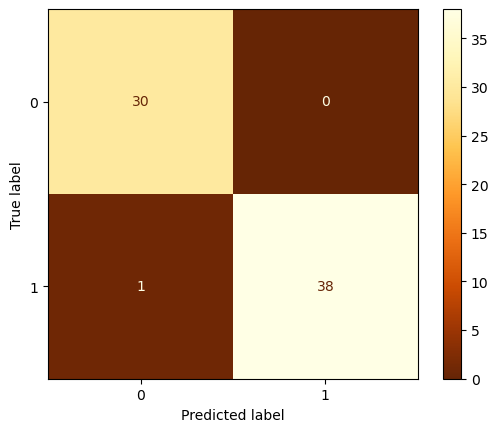

In [14]:
#only XGB
y_pred = xgb_models[4].predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
print(classification_report(y_test, y_pred))

In [19]:
# Global model fit
global_model = XGBClassifier(n_estimators=500, n_jobs=-1, max_depth=4, eta=0.1, colsample_bytree=0.67)
global_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.67,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', ...)

Accuracy: 98.55%
F1-score: 98.53%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.99        39

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



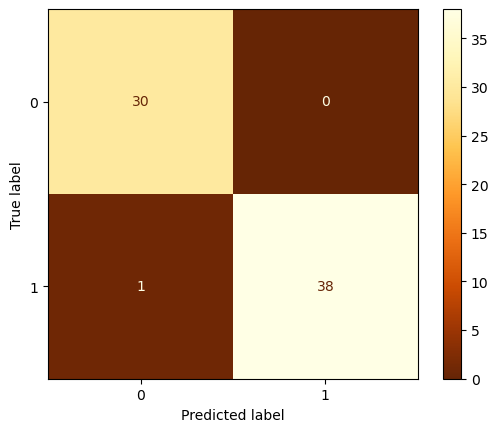

In [24]:
# Global model test
y_pred = global_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100))
f1 = f1_score(y_test, y_pred, average = 'macro')
print("F1-score: %.2f%%" % (f1 * 100))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
print(classification_report(y_test, y_pred))

Accuracy: 86.96%
F1-score: 86.78%
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.89      0.87      0.88        39

    accuracy                           0.87        69
   macro avg       0.87      0.87      0.87        69
weighted avg       0.87      0.87      0.87        69



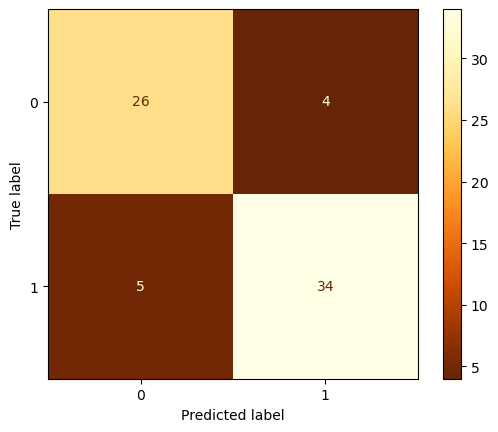

In [23]:
# Old model test

## Model8
X = train.drop(columns=['label'])
X_test = test.drop(columns=['label'])

## Model4
# X = train.drop(columns=['label', 0, 1, 2, 3, 4, 5])
# X_test = test.drop(columns=['label', 0, 1, 2, 3, 4, 5])

y = train.label
y_test = test.label

model = XGBClassifier(n_estimators=500, n_jobs=-1, max_depth=4, eta=0.1, colsample_bytree=0.67, early_stopping_rounds=300,)
model.load_model(r"C:\Users\user\Desktop\wafer\Model\XGBoost_model8_1116.json")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = 'macro')
print("Accuracy: %.2f%%" % (accuracy * 100))
print("F1-score: %.2f%%" % (f1 * 100))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
print(classification_report(y_test, y_pred))

# 不同模型比較

## RF

In [61]:
from sklearn.ensemble import RandomForestClassifier
train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)

FOLDS = 10
SEED = 42
xgb_models = []
xgb_oof = []
predictions = np.zeros(len(test))
f_imp = []

counter = 1
X = train.drop(columns=['label'])
y = train.label
X_test = test.drop(columns=['label'])
y_test = test.label
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    if (fold + 1)%5 == 0 or (fold + 1) == 1:
        print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    watchlist = [(X_train, y_train), (X_valid, y_valid)]

    # XGboost model and fit
    model = RandomForestClassifier(n_estimators=100, random_state=42) 
    model.fit(X_train, y_train)

    val_preds = model.predict(X_valid)
    val_score = accuracy_score(y_valid, val_preds)
    test_preds = model.predict(X_test)
    test_score = accuracy_score(y_test, test_preds)

    idx_pred_target = np.vstack([val_idx,  val_preds, y_valid]).T # shape(len(val_idx), 3)
    #f_imp.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f'{" "*20} val_acc:{blu}{val_score:.5f}{res} ')

    xgb_oof.append(idx_pred_target)
    xgb_models.append(model)
    
if val_score > 0.80:
        test_preds = model.predict_proba(X_test)[:,1] 
        predictions += test_preds
        counter += 1

predictions /= counter
mean_val_auc = get_mean_auc(xgb_oof)
print('*'*45)
print(f'{red}Mean{res} acc: {red}{mean_val_auc:.5f}{res}')




######################## Training FOLD 1 ########################
                     val_acc:0.90566 
                     val_acc:0.85849 
                     val_acc:0.85849 
                     val_acc:0.85849 
######################## Training FOLD 5 ########################
                     val_acc:0.92453 
                     val_acc:0.93396 
                     val_acc:0.88571 
                     val_acc:0.86667 
                     val_acc:0.94286 
######################## Training FOLD 10 ########################
                     val_acc:0.90476 
*********************************************
Mean acc: 0.88571


In [62]:
# 預測測試集
test_acc = []
X_test = test.drop(columns=['label'])
y_test = test.label
for i in range(10):
    y_pred = xgb_models[i].predict(X_test)
    # 計算Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    test_acc.append(accuracy)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100))
print('*'*45)
print(f'{red}Mean{res} acc: {red}{sum(test_acc)/10:.5f}{res}')


No.0 Accuracy: 76.47%
No.1 Accuracy: 82.35%
No.2 Accuracy: 76.47%
No.3 Accuracy: 79.41%
No.4 Accuracy: 76.47%
No.5 Accuracy: 73.53%
No.6 Accuracy: 79.41%
No.7 Accuracy: 76.47%
No.8 Accuracy: 76.47%
No.9 Accuracy: 82.35%
*********************************************
Mean acc: 0.77941


              precision    recall  f1-score   support

           0       0.90      0.96      0.93       471
           1       0.95      0.87      0.91       390

    accuracy                           0.92       861
   macro avg       0.93      0.92      0.92       861
weighted avg       0.92      0.92      0.92       861



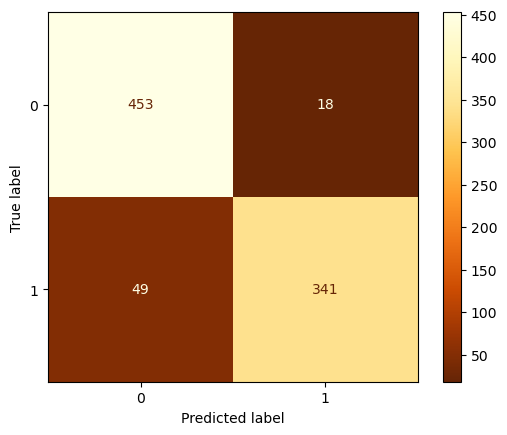

In [26]:
y_pred = xgb_models[9].predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
print(classification_report(y_test, y_pred))

## LGBM

In [63]:
# LGBM
import lightgbm as lgb
FOLDS = 10
SEED = 42
xgb_models = []
xgb_oof = []
predictions = np.zeros(len(test))
f_imp = []

counter = 1
X = train.drop(columns=['label'])
y = train.label
X_test = test.drop(columns=['label'])
y_test = test.label
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    if (fold + 1)%5 == 0 or (fold + 1) == 1:
        print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    watchlist = [(X_train, y_train), (X_valid, y_valid)]

    # XGboost model and fit
    model = lgb.LGBMClassifier(n_estimators=100, random_state=42)  # 選擇樹的數量和隨機種子
    model.fit(X_train, y_train)

    val_preds = model.predict(X_valid)
    val_score = accuracy_score(y_valid, val_preds)
    test_preds = model.predict(X_test)
    test_score = accuracy_score(y_test, test_preds)

    idx_pred_target = np.vstack([val_idx,  val_preds, y_valid]).T # shape(len(val_idx), 3)
    #f_imp.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f'{" "*20} val_acc:{blu}{val_score:.5f}{res} ')

    xgb_oof.append(idx_pred_target)
    xgb_models.append(model)
    
if val_score > 0.80:
        test_preds = model.predict_proba(X_test)[:,1] 
        predictions += test_preds
        counter += 1

predictions /= counter
mean_val_auc = get_mean_auc(xgb_oof)
print('*'*45)
print(f'{red}Mean{res} acc: {red}{mean_val_auc:.5f}{res}')




######################## Training FOLD 1 ########################
                     val_acc:0.91509 
                     val_acc:0.90566 
                     val_acc:0.87736 
                     val_acc:0.89623 
######################## Training FOLD 5 ########################
                     val_acc:0.90566 
                     val_acc:0.91509 
                     val_acc:0.90476 
                     val_acc:0.90476 
                     val_acc:0.94286 
######################## Training FOLD 10 ########################
                     val_acc:0.94286 
*********************************************
Mean acc: 0.90390


In [64]:
# 預測測試集
test_acc = []
X_test = test.drop(columns=['label'])
y_test = test.label
for i in range(10):
    y_pred = xgb_models[i].predict(X_test)
    # 計算Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    test_acc.append(accuracy)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100))
print('*'*45)
print(f'{red}Mean{res} acc: {red}{sum(test_acc)/10:.5f}{res}')


No.0 Accuracy: 76.47%
No.1 Accuracy: 73.53%
No.2 Accuracy: 76.47%
No.3 Accuracy: 67.65%
No.4 Accuracy: 70.59%
No.5 Accuracy: 73.53%
No.6 Accuracy: 70.59%
No.7 Accuracy: 73.53%
No.8 Accuracy: 76.47%
No.9 Accuracy: 70.59%
*********************************************
Mean acc: 0.72941


              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.74      0.85      0.79        20

    accuracy                           0.74        34
   macro avg       0.73      0.71      0.72        34
weighted avg       0.73      0.74      0.73        34



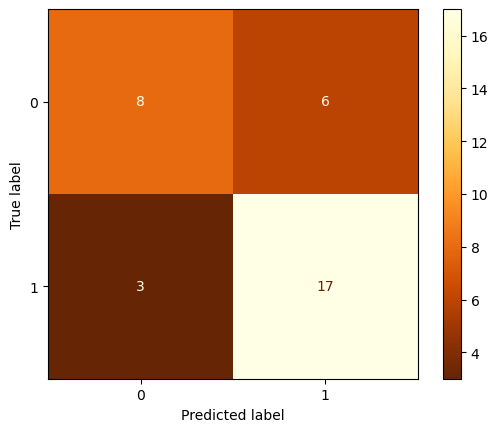

In [65]:
y_pred = xgb_models[5].predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
print(classification_report(y_test, y_pred))

## CatBoost

In [77]:
#reference: https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e7-2023-eda-and-submission
from catboost import CatBoostClassifier

FOLDS = 10
SEED = 42
xgb_models = []
xgb_oof = []
predictions = np.zeros(len(test))
f_imp = []

counter = 1

## Model8
X = train.drop(columns=['label'])
X_test = test.drop(columns=['label'])

## Model4
# X = train.drop(columns=['label', 0, 1, 2, 3, 4, 5])
# X_test = test.drop(columns=['label', 0, 1, 2, 3, 4, 5])

### calculate class weights based on the training data
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train.label)

y = train.label
y_test = test.label

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    if (fold + 1)%5 == 0 or (fold + 1) == 1:
        print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    watchlist = [(X_train, y_train), (X_valid, y_valid)]

    # Catboost model and fit
    model=CatBoostClassifier(iterations=1500,
                         eval_metric='Accuracy',
                        verbose=0)
    model.fit(X_train, y_train, eval_set=watchlist, verbose=0)
    val_preds = model.predict(X_valid)
    val_score = accuracy_score(y_valid, val_preds)
    test_preds = model.predict(X_test)
    test_score = accuracy_score(y_test, test_preds)

    idx_pred_target = np.vstack([val_idx,  val_preds, y_valid]).T # shape(len(val_idx), 3)
    #f_imp.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f'{" "*20} val_acc:{blu}{val_score:.5f}{res} ')

    xgb_oof.append(idx_pred_target)
    xgb_models.append(model)


if val_score > 0.80:
        test_preds = model.predict_proba(X_test)[:,1] 
        predictions += test_preds
        counter += 1

predictions /= counter
mean_val_auc = get_mean_auc(xgb_oof)
mean_val_acc = get_mean_acc(xgb_oof)
print('*'*45)
print(f'{red}Mean{res} auc: {red}{mean_val_auc:.5f}{res}')
print(f'{red}Mean{res} acc: {red}{mean_val_acc:.5f}{res}')

######################## Training FOLD 1 ########################
                     val_acc:0.57143 
                     val_acc:0.92857 
                     val_acc:1.00000 
                     val_acc:0.84615 
######################## Training FOLD 5 ########################
                     val_acc:0.92308 
                     val_acc:0.92308 
                     val_acc:0.76923 
                     val_acc:0.84615 
                     val_acc:1.00000 
######################## Training FOLD 10 ########################
                     val_acc:1.00000 
*********************************************
Mean auc: 0.87013
Mean acc: 0.87879


In [78]:
# 預測測試集
test_acc = []
X_test = test.drop(columns=['label'])
y_test = test.label
for i in range(10):
    y_pred = xgb_models[i].predict(X_test)
    # 計算Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    test_acc.append(accuracy)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100))
print('*'*45)
print(f'{red}Mean{res} acc: {red}{sum(test_acc)/10:.5f}{res}')


No.0 Accuracy: 76.47%
No.1 Accuracy: 79.41%
No.2 Accuracy: 82.35%
No.3 Accuracy: 85.29%
No.4 Accuracy: 82.35%
No.5 Accuracy: 82.35%
No.6 Accuracy: 76.47%
No.7 Accuracy: 76.47%
No.8 Accuracy: 79.41%
No.9 Accuracy: 79.41%
*********************************************
Mean acc: 0.80000


## Soft Voting

In [44]:
from sklearn.ensemble import VotingClassifier
# 定義三個模型
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lgbm_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)

FOLDS = 10
SEED = 42
xgb_models = []
xgb_oof = []
predictions = np.zeros(len(test))
f_imp = []

counter = 1
X = train.drop(columns=['label'])
y = train.label
X_test = test.drop(columns=['label'])
y_test = test.label
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    if (fold + 1)%5 == 0 or (fold + 1) == 1:
        print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    watchlist = [(X_train, y_train), (X_valid, y_valid)]

    # Voting model and fit
    model = VotingClassifier(estimators=[
        ('xgb', xgb_model),
        #('rf', rf_model),
        ('lgbm', lgbm_model)
    ], voting='soft')
    model.fit(X_train, y_train)

    val_preds = model.predict(X_valid)
    val_score = accuracy_score(y_valid, val_preds)
    test_preds = model.predict(X_test)
    test_score = accuracy_score(y_test, test_preds)

    idx_pred_target = np.vstack([val_idx,  val_preds, y_valid]).T # shape(len(val_idx), 3)
    #f_imp.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f'{" "*20} val_acc:{blu}{val_score:.5f}{res} ')

    xgb_oof.append(idx_pred_target)
    xgb_models.append(model)
    
if val_score > 0.80:
        test_preds = model.predict_proba(X_test)[:,1] 
        predictions += test_preds
        counter += 1

predictions /= counter
mean_val_auc = get_mean_auc(xgb_oof)
print('*'*45)
print(f'{red}Mean{res} acc: {red}{mean_val_auc:.5f}{res}')




######################## Training FOLD 1 ########################
                     val_acc:0.95300 
                     val_acc:0.95561 
                     val_acc:0.96084 
                     val_acc:0.94125 
######################## Training FOLD 5 ########################
                     val_acc:0.95953 
                     val_acc:0.96214 
                     val_acc:0.95953 
                     val_acc:0.95822 
                     val_acc:0.95300 
######################## Training FOLD 10 ########################
                     val_acc:0.95431 
*********************************************
Mean acc: 0.95542


In [45]:
# 預測測試集
test_acc = []
X_test = test.drop(columns=['label'])
y_test = test.label
for i in range(10):
    y_pred = xgb_models[i].predict(X_test)
    # 計算Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    test_acc.append(accuracy)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100))
print('*'*45)
print(f'{red}Mean{res} acc: {red}{sum(test_acc)/10:.5f}{res}')


No.0 Accuracy: 93.84%
No.1 Accuracy: 94.19%
No.2 Accuracy: 94.19%
No.3 Accuracy: 93.73%
No.4 Accuracy: 94.31%
No.5 Accuracy: 94.19%
No.6 Accuracy: 93.84%
No.7 Accuracy: 94.43%
No.8 Accuracy: 93.73%
No.9 Accuracy: 94.19%
*********************************************
Mean acc: 0.94065


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       471
           1       0.94      0.94      0.94       390

    accuracy                           0.94       861
   macro avg       0.94      0.94      0.94       861
weighted avg       0.94      0.94      0.94       861



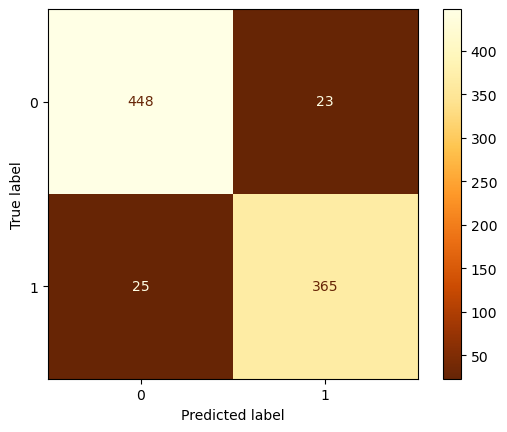

In [46]:
y_pred = xgb_models[7].predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
print(classification_report(y_test, y_pred))

# 儲存模型

In [21]:
#json
global_model.save_model("KID_Model10_XGBoost20240812.json")

In [22]:
#joblib 
from joblib import dump, load
dump(global_model, "KID_Model10_XGBoost20240812.joblib")

['KID_Model10_XGBoost20240812.joblib']

# F16 預測分布

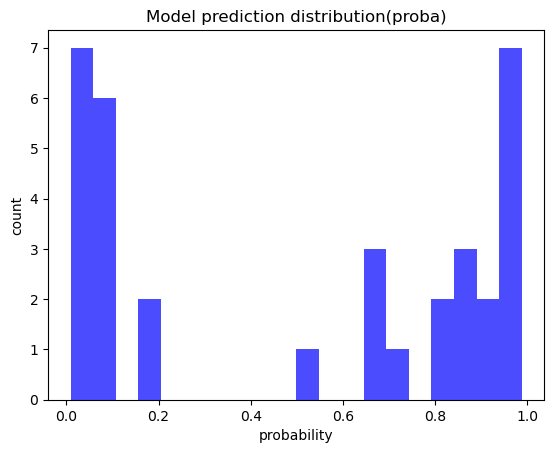

Accuracy: 73.53%
              precision    recall  f1-score   support

           0       0.86      0.43      0.57        14
           1       0.70      0.95      0.81        20

    accuracy                           0.74        34
   macro avg       0.78      0.69      0.69        34
weighted avg       0.77      0.74      0.71        34



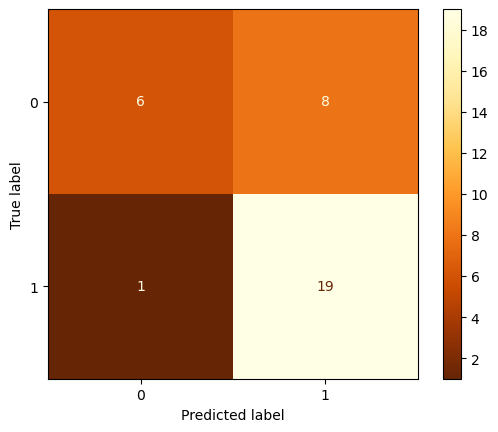

In [357]:
import matplotlib.pyplot as plt
# 只有 XGB 的部分
model_path = r"C:\Users\user\Desktop\wafer\Model\GF1_Model8_XGBoost_sythesis20240128.joblib"
model = load(model_path)
# model = XGBClassifier(n_estimators=500, n_jobs=-1, max_depth=4, eta=0.1, colsample_bytree=0.67, early_stopping_rounds=300,)
# model_path = r"C:\Users\user\Desktop\wafer\Model\XGBoost_model4_1226.json"
# model.load_model(model_path)

# X_test = test.drop(columns=['label', 0, 1, 2, 3, 4, 5])
X_test = test.drop(columns=['label'])
# y_test = test.label

# 使用 predict_proba 方法得到機率
y_pred_proba = model.predict_proba(X_test)

# 假設 y_pred_proba_class_1 是屬於第一類的機率
y_pred_proba_class_1 = y_pred_proba[:, 1]
# 繪製直方圖
plt.hist(y_pred_proba_class_1, bins=20, color='blue', alpha=0.7)
plt.xlabel('probability')
plt.ylabel('count')
plt.title('Model prediction distribution(proba)')
plt.show()
# 設置閾值
threshold = 0.05

# 將機率轉換為二元類別
binary_predictions = (y_pred_proba_class_1 > threshold).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))
# 計算混淆矩陣
cm = confusion_matrix(y_test, binary_predictions)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

# 顯示分類報告
print(classification_report(y_test, binary_predictions))